In [1]:
# these are for importing data
import pystac
import fsspec
import xarray as xr

# keep attributes throughout opeartions
xr.set_options(keep_attrs=True)

# this is for parallel computing
from dask_gateway import GatewayCluster

# these are for geospatial data
import cartopy.crs as ccrs
import geopandas as gpd
import rasterio as rio
#import cv2

# these are for dealing with arrays
import numpy as np
import matplotlib.pyplot as plt

## DATA LOADING

In [2]:
# accessing collection 
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-annual-na"
collection = pystac.read_file(url)

asset = collection.assets["zarr-https"]

# open as xarray dataset
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

In [3]:
# extract crs from ds
lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
# https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
crs = ccrs.LambertConformal(**prj_kwargs)

In [4]:
# import CA shapefile
ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

# match CRS
ca_lambert = ca_shape.to_crs(crs)

## CLIMATE AVERAGE AND REGIONS FUNCTIONS

In [5]:
# calculate the average tmax or tmin temperature over the time period [year-n+1,year]
# tmax_timin = string 'tmax' or 'tmin' depending on whether you want to compute min or max avg temperature
# year, n = integers
# for best practices according to the World Meteorological Organization, n=30 (see notes on Case Study Diary)

def ca_tmaxmin_avg(tmax_tmin,year,n=30):
    if (year-n+1<1981 or 2019<year):
        print('time range outside the dataset extent')
        return 

    # select time period and write crs
    years = ds.sel(time=slice(str(year-n+1),str(year)))[tmax_tmin]
    years = years.rio.write_crs(crs)
    
    # clip over CA and calcualte avg
    ca_avg = years.rio.clip(ca_lambert.geometry, ca_lambert.crs)
    ca_avg = ca_avg.mean(dim="time")
    
    # update attributes
    ca_avg.attrs['year']=year
    ca_avg.attrs['time_period']=n
    if tmax_tmin == 'tmax':
        ca_avg.attrs['long_name'] = 'average of daily maximum temperature, over years ['+str(year-n+1)+','+str(year)+']'
    else:
        ca_avg.attrs['long_name'] =  'average of daily minimum temperature, over years ['+str(year-n+1)+','+str(year)+']'
         
    return ca_avg 

In [6]:
# calculate the average temperature over the time period [year-n+1,year]
# for best practices according to the World Meteorological Organization, n=30 (see notes on Case Study Diary)
def ca_avg_temp(year,n=30):

    if (year-n+1<1981 or 2019<year):
        print('time range outside the dataset extent')
        return 
    
    ca_min = ca_tmaxmin_avg('tmin',year,n)
    ca_max = ca_tmaxmin_avg('tmax',year,n)
    # remove weird values?
    #ca_max = ca_max.where(ca_max>0)
    avg = (ca_max + ca_min)/2
    avg.attrs['long_name'] =  'average temperature, over years ['+str(year-n+1)+','+str(year)+']'
    avg.attrs.pop('cell_methods')
    
    return avg

In [7]:
#clim = xarray.DataArray of average temperature

def clim_regions(clim):
    # extract numpy.ndarray
    trgns = clim.to_numpy()
    # establish thresholds
    k = [0,10,18,24]
    # group into regions
    trgns[np.where( (k[0]<=trgns) & (trgns<k[1]))] = 3
    trgns[np.where( trgns< k[0])] = 2
    trgns[np.where( (k[1]<=trgns) & (trgns<k[2]))] = 4
    trgns[np.where( (k[2]<=trgns) & (trgns<k[3]))] = 5
    trgns[np.where(k[3]<=trgns)] = 6
    
    # create xarray.DataArray with np.ndarray
    t_regions = xr.DataArray(
        data= trgns,
        dims= clim.dims,
        coords= clim.coords,
        attrs= clim.attrs
        )
    
    # update attributes
    t_regions.attrs.pop('units')
    t_regions.attrs['long_name'] = 'climate regions, year ' + str(clim.attrs['year'])
    # include a dictionary of temp regions
    d = { 2: 'polar or boreal: temp less than '+str(k[0]) ,
        3: 'cold temperate: temp in ['+str(k[0])+','+str(k[1])+')',
        4: 'warm temperate: temp in ['+str(k[1])+','+str(k[2])+')',
        5: 'subtropical: temp in ['+str(k[2])+','+str(k[3])+')',
        6: 'tropical: temp geq than '+str(k[3]) } 
    t_regions.attrs['regions_codes'] = d
    
    return t_regions


In [8]:
# recent, past = xarray.DataArrays of climate regions
def clim_rgns_increase(recent, past):
    increase = recent-past
    increase = increase.where(increase>0)
    
    increase.attrs.pop('year')
    increase.attrs.pop('time_period')
    increase.attrs.pop('regions_codes')
    increase.attrs['long_name'] = 'increase in climate regions from '+str(past.attrs['year'])+' to '+str(recent.attrs['year'])
    increase.attrs['years_compared'] = (past.attrs['year'],recent.attrs['year'])
    return increase

## EXAMPLES

In [ ]:
ca_max = ca_tmaxmin_avg('tmax',2019)
ca_max.plot()
ca_max.attrs

In [ ]:
ca_min = ca_tmaxmin_avg('tmin',2019)
ca_min.plot()
ca_min.attrs

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'average temperature, over years [1990,2019]',
 'units': 'degrees C',
 'year': 2019,
 'time_period': 30}

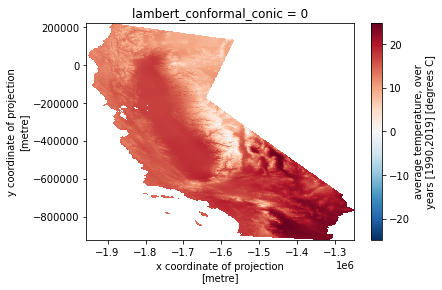

In [10]:
ca_avg19 = ca_avg_temp(2019)
ca_avg19.plot()
ca_avg19.attrs

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'climate regions, year 2019',
 'year': 2019,
 'time_period': 30,
 'regions_codes': {2: 'polar or boreal: temp less than 0',
  3: 'cold temperate: temp in [0,10)',
  4: 'warm temperate: temp in [10,18)',
  5: 'subtropical: temp in [18,24)',
  6: 'tropical: temp geq than 24'}}

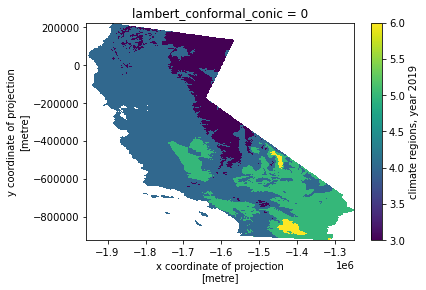

In [11]:
ca_rgns19 = clim_regions(ca_avg19)
ca_rgns19.plot()
ca_rgns19.attrs

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'climate regions, year 2010',
 'year': 2010,
 'time_period': 30,
 'regions_codes': {2: 'polar or boreal: temp less than 0',
  3: 'cold temperate: temp in [0,10)',
  4: 'warm temperate: temp in [10,18)',
  5: 'subtropical: temp in [18,24)',
  6: 'tropical: temp geq than 24'}}

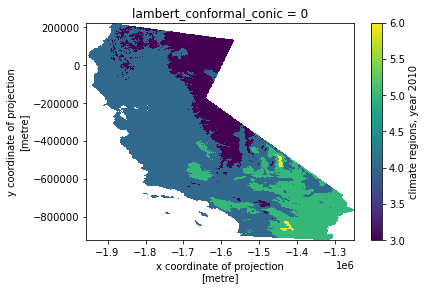

In [12]:
ca_avg10 = ca_avg_temp(2010)
ca_rgns10 = clim_regions(ca_avg10)
ca_rgns10.plot()
ca_rgns10.attrs

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'increase in climate regions from 2010 to 2019',
 'years_compared': (2010, 2019)}

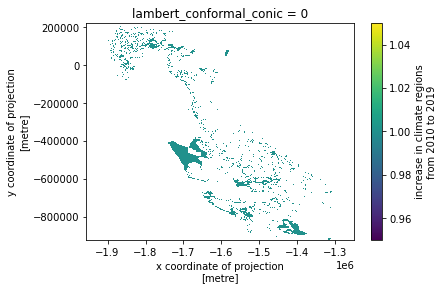

In [13]:
inc = clim_rgns_increase(ca_rgns19,ca_rgns10)
inc.plot()
inc.attrs

## SAVING FILE

In [31]:
#https://xarray.pydata.org/en/stable/user-guide/io.html
outfp = "/home/jovyan/climate_layer/clim_increase_10_19.nc"
inc.to_netcdf(outfp)

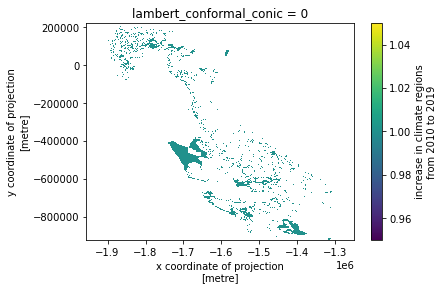

In [33]:
check = xr.open_dataarray(outfp)
check.plot()

## OUTLIERS FUNCTION TRIALS

In [29]:
# def dilate_outlier(array, less_greater, thresh):
#     if less_greater == "less":
#         outliers = array.where( array<thresh, 0) #keep where array<thresh, make everything else 0
#     else :
#         outliers = array.where( array>thresh, 0) #keep where array>thresh, make everything else 0
#     outliers = outliers.where( outliers== 0, 1)
    
#     kernel = np.ones((10,10), np.uint8)
#     thick_outliers = cv2.dilate(outliers.to_numpy(), kernel, iterations=1)

#     thick_outliers_XA = xr.DataArray(
#         data= thick_outliers,
#         dims= array.dims,
#         coords= array.coords,
#         attrs= array.attrs
#         )
    
#     return thick_outliers_XA

In [ ]:
# outliers = dilate_outlier(ca_max,"less",0) #flag everything less than 0

# fig, ax = plt.subplots(figsize = (10,10))
# outliers.plot(ax=ax)
# ca_lambert.plot(ax=ax,edgecolor='yellow', facecolor="none")



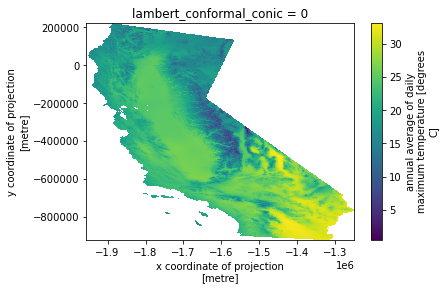

In [22]:
# ca_max = ca_max.where(ca_max>0)

<AxesSubplot:title={'center':'lambert_conformal_conic = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

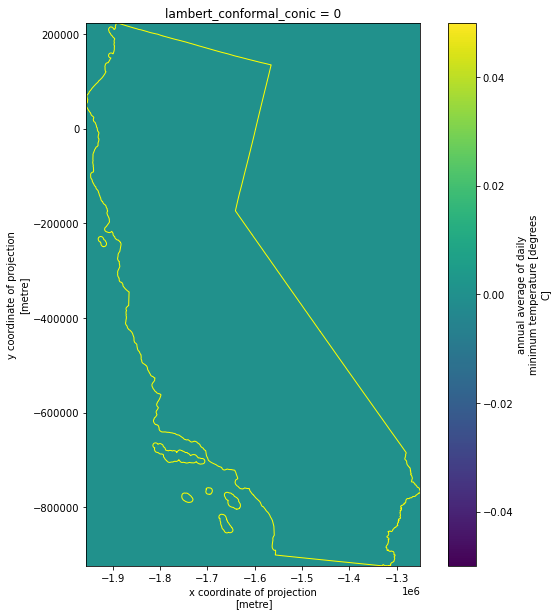

In [24]:
# outliers_avg = dilate_outlier(ca_avg,"less",-10) #flag everything less than -10

# fig, ax = plt.subplots(figsize = (10,10))
# outliers_avg.plot(ax=ax)
# ca_lambert.plot(ax=ax,edgecolor='yellow', facecolor="none")

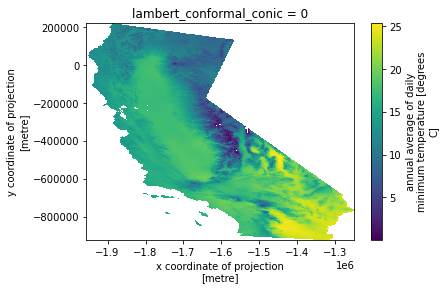

In [22]:
#ca_avg.where(ca_avg>0).plot()

<AxesSubplot:title={'center':'lambert_conformal_conic = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

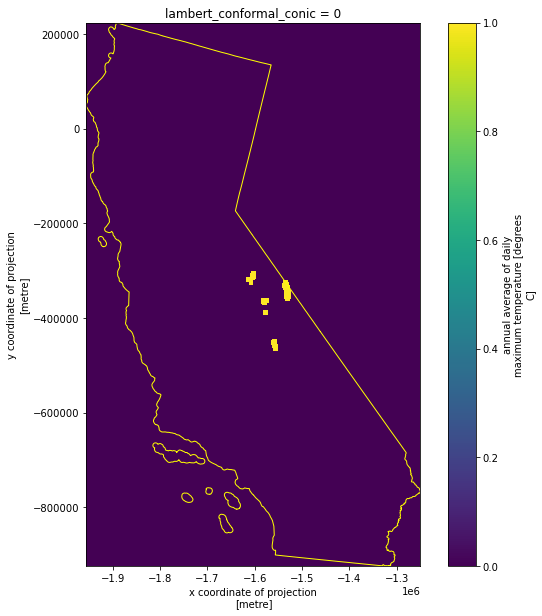

In [30]:
# outliers_avg2 = dilate_outlier(ca_avg2,"less",0) #flag everything less than 0

# fig, ax = plt.subplots(figsize = (10,10))
# outliers_avg2.plot(ax=ax)
# ca_lambert.plot(ax=ax,edgecolor='yellow', facecolor="none")